# Orca call detection

In this jupyter notebook I will present the code for the approach I used to detect precise time of Orca Calls. I used a unidirectional RNN model for this purpose. Model is paired with sliding windows technique to give precise time of orca calls in long audio samples.


Lets get started! Run the following cell to load the package we are going to use

In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import * # includes helper functions
import math

%matplotlib inline

C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Spectrogram
I have added a demo data of 1 training sample. Lets load it's audio file and spectrogram.

In [3]:
IPython.display.Audio("data/XY_demo/0_7_test.wav")

C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:7674: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


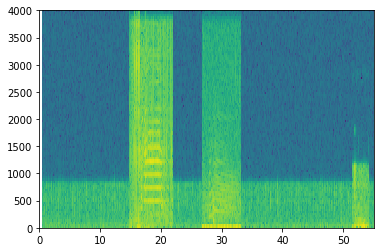

In [4]:
x = graph_spectrogram("data/XY_demo/0_7_test.wav")

In [5]:
_, data = wavfile.read("data/XY_demo/0_7_test.wav")
print("Time steps in audio recording before spectrogram", data[:,0].shape)
print("Time steps in input after spectrogram", x.shape)

Time steps in audio recording before spectrogram (441000,)
Time steps in input after spectrogram (101, 5511)


### Let's define some variables depending on above results.

In [6]:
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

Note that even with 10 seconds being our default training example length, 10 seconds of time can be discretized to different numbers of value. You've seen 441000 (raw audio) and 5511 (spectrogram). In the former case, each step represents $10/441000 \approx 0.000023$ seconds. In the second case, each step represents $10/5511 \approx 0.0018$ seconds. 

For the 10sec of audio, the key values you will see are:

- $441000$ (raw audio)
- $5511 = T_x$ (spectrogram output, and dimension of input to the neural network). 
- $10000$ (used by the `pydub` module to synthesize audio) 
- $1375 = T_y$ (the number of steps in the output of the GRU ). 

Note that each of these representations correspond to exactly 10 seconds of time. It's just that they are discretizing them to different degrees. All of these are hyperparameters and can be changed (except the 441000, which is a function of the microphone). We have chosen values that are within the standard ranges uses for speech systems. 

Consider the $T_y = 1375$ number above. This means that for the output of the model, we discretize the 10s into 1375 time-intervals (each one of length $10/1375 \approx 0.0072$s) and try to predict for each of these intervals whether someone recently finished saying "activate." 

Consider also the 10000 number above. This corresponds to discretizing the 10sec clip into 10/10000 = 0.001 second itervals. 0.001 seconds is also called 1 millisecond, or 1ms. So when we say we are discretizing according to 1ms intervals, it means we are using 10,000 steps. 


In [7]:
Ty = 1375 # The number of time steps in the output of our model

### Lets load Demo data

In [8]:
X_demo = np.load("./data/XY_demo/X_demo.npy")
Y_demo = np.load("./data/XY_demo/Y_demo.npy")

# 1. Model

The model will use 1-D convolutional layers, GRU layers, and dense layers. Let's import required packages and build our RNN model.

In [10]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

Here is the architecture we will use. Take some time to look over the model and see if it makes sense. 

<img src="images/model.png" style="width:600px;height:600px;">
<center> **Figure 3** </center>

One key step of this model is the 1D convolutional step (near the bottom of Figure 3). It inputs the 5511 step spectrogram, and outputs a 1375 step output, which is then further processed by multiple layers to get the final $T_y = 1375$ step output. This layer plays a role similar to the 2D convolutions of extracting low-level features and then possibly generating an output of a smaller dimension. 

Computationally, the 1-D conv layer also helps speed up the model because now the GRU  has to process only 1375 timesteps rather than 5511 timesteps. The two GRU layers read the sequence of inputs from left to right, then ultimately uses a dense+sigmoid layer to make a prediction for $y^{\langle t \rangle}$. Because $y$ is binary valued (0 or 1), we use a sigmoid output at the last layer to estimate the chance of the output being 1.

Note that we use a uni-directional RNN rather than a bi-directional RNN. If we want to detect orca calls in real time then we have to use uni-directional RNN. Otherwise in Bi-RNN we have to wait for the input to complete before predicting. To get better performance on pre recorded audio files we can use Bi-RNN.

In [11]:
def model(input_shape):

    
    X_input = Input(shape = input_shape)
    
    X = Conv1D(196, 15, strides=4)(X_input)                                 # CONV1D
    X = BatchNormalization()(X)                            # Batch normalization
    X = Activation('relu')(X)                                 # ReLu activation
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)

    X = GRU(units = 128, return_sequences = True)(X)  # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    
    X = GRU(units = 128, return_sequences = True)(X)   # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    
    return model

In [12]:
model = model(input_shape = (Tx, n_freq))

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5511, 101)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1375, 196)         297136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1375, 196)         784       
_________________________________________________________________
activation_1 (Activation)    (None, 1375, 196)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1375, 196)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 1375, 128)         124800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1375, 128)         0         
__________

In [28]:
opt = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
model.fit(X_demo, Y_demo)

Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 1.3641 - acc: 0.5033


## Pre-trained Model

This type of model could take very long to train. So, I have added a pre-trained model for demo.

In [15]:
model = load_model('./checkpoints/modelOld.h5')

In [16]:
loss, acc = model.evaluate(X_demo, Y_demo)
print("Demo audio accuracy = ", acc)
print("Demo audio loss = ", loss)

1/1 [==============================] - 1s 1s/step
Demo audio accuracy =  0.942545473575592
Demo audio loss =  0.20363934338092804


# 2. Using the model to detect orca calls in variable length Inputs

### Redefine graph_spectrogram()

First I will redefine `graph_spectrogram()` function with some little changes.

In [17]:
def graph_spectrogram(data):
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

### Pad function

This function can pad short audio clips. Function takes 2 arguments, the data itself and the stride.

In [18]:
def get_padded_data(data, stride):
    if data.shape[0]>=441000:
        slides_before_padding = math.ceil(((data.shape[0]-441000)/stride))
        padding = (slides_before_padding*stride) - data.shape[0] + 441000
        padded_data = np.zeros((padding + data.shape[0], 2))
        padded_data[0:len(data[:])] = data[:]
    else:
        padding = 441000 - data.shape[0]
        padded_data = np.zeros((padding + data.shape[0], 2))
        padded_data[0:len(data[:])] = data[:]
    return padded_data

### Detect Calls

Below function `detect_calls()` uses sliding window approach to detect multiple Orca Calls. Window is of 10 second length i.e. same as the input size of our model. 

Function will return an array of predictions at different output timestamps. This array can be of variable length depending on input data. Prediction will be `1` at the timestamp when orca call ends, and it will be `0` elsewhere.

The function takes 2 arguments:
* `filename`- Name of the wav file.
* `chunk` - Describe how much you want to slide your window in seconds.(ex - of chunk=0.5 then 10 second window will slide for every 0.5 second) 

In [19]:
def detect_calls(filename, chunk):    
    rate, data = wavfile.read(filename)
    stride = int(44100*chunk)
    pred_stride = 70   
    data = get_padded_data(data, stride)
    total_slides = int(((data.shape[0]-441000)/stride)) + 1
    
    total_preds_len = ((total_slides-1)*pred_stride) + 1375
    preds = np.zeros((1, total_preds_len, 1), dtype=np.float32)
    length = data.shape[0]
#     print("Preds len: "+str(total_preds_len))
    start = 0
    pred_start = 0
    i = 0
#     print(total_slides)
    j=1
    while start+441000 <= data.shape[0]:
#         print(j)
        j+=1
        segment = data[start:start+441000]
#         print("Seg Len : " + str(len(segment)))
        x = graph_spectrogram(segment)
        x  = x.swapaxes(0,1)
        x = np.expand_dims(x, axis=0)
        model_preds = model.predict(x)
        for i in range(len(model_preds[0,:,0])):
#             print("first half : "+str(pred_start+i))
            if  preds[0,pred_start+i, 0] < model_preds[0, i, 0]:
                preds[0,pred_start+i, 0] = model_preds[0, i, 0]
        
        start = start+stride
        pred_start = pred_start + pred_stride
                    
    return preds

#### Let's run this on our demo audio file

In [20]:
filename = "./data/XY_demo/joined1.wav"
r, data = wavfile.read(filename)
IPython.display.Audio(filename)

C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:7674: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


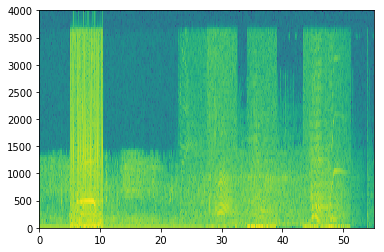

In [21]:
preds = detect_calls(filename, 0.5)

## Precise time

Now let's use above predictions to get precise time of orca calls. Below function will output the time of orca calls and it will also generate an audio file with chime sound whenever an orca call ends. Let's run this function.

In [24]:
chime_file = "audio_examples/chime.wav"
def chime_and_pred(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    start_of_orca = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            print("Start Time : " + str(((i-75) / Ty) * audio_clip.duration_seconds))
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')

In [25]:
chime_and_pred(filename, preds, 0.5)

Start Time : 4.314206128133705
Start Time : 9.020612813370475
Start Time : 11.074317548746519


Let's hear the output file with chime sound.

In [26]:
IPython.display.Audio("./chime_output.wav")

# Note

Model is not perfect yet. It still needs a lot more training on more samples.